In [2]:
## Load Dataset Container from pickle with already preprocessed data
import pickle
import sklearn
from sklearn import linear_model
import autoencodix as acx
from autoencodix.configs.ontix_config import OntixConfig
from syne_tune import Reporter

file_pkl = "./large_sc_data/census-processed-chatgpt.pkl"

with open(file_pkl, "rb") as f:
	acx_container = pickle.load(f)

print(acx_container.train.data.shape, acx_container.valid.data.shape, acx_container.test.data.shape)

print(acx_container.train.metadata['disease'])

# epochs = 5
# checkpoint_interval = 5
# batch_size = 5000
# drop_p = 0.1
# enc_factor = 2
# weight_decay = 1e-2
# beta = 0.01
# learning_rate = 1e-3
# n_layers = 3
# loss_reduction = "sum"
# ontology_name = "chatgpt_ontology__"
# tasks = "$".join(["cell_type", "tissue", "development_stage", "sex"]) ## Include disease later when available
# # float_precision = "bf16-mixed"


# scconfig = OntixConfig(
# 	## Fixed params
# 	epochs=epochs,
# 	checkpoint_interval= checkpoint_interval,
# 	loss_reduction= loss_reduction,
# 	## Tunable params
# 	batch_size= batch_size,
# 	drop_p= drop_p,
# 	enc_factor= enc_factor,
# 	weight_decay= weight_decay,
# 	beta= beta,
# 	learning_rate= learning_rate,
# 	n_layers= n_layers,
# 	# float_precision= float_precision,
# )


# ont_files = [
# 	# Order from Latent Dim -> Hidden Dim -> Input Dim
# 	f"./llm_ontologies/{ontology_name}ensembl_level1.tsv",
# 	f"./llm_ontologies/{ontology_name}ensembl_level2.tsv",
# 	]

# ontix = acx.Ontix(
# 	data=acx_container,
# 	ontologies=ont_files,
# 	config=scconfig
# 	)

# ontix.run()

# ## Embedding Evaluation
# sklearn.set_config(enable_metadata_routing=True)

# sklearn_ml_class = linear_model.LogisticRegression(
# 							solver="sag",
# 							n_jobs=-1,
# 							class_weight="balanced",
# 							max_iter=200,
# ) 
# sklearn_ml_regression = linear_model.LinearRegression() ## Unused, only classification tasks
# own_metric_class = 'roc_auc_ovo'  
# own_metric_regression = 'r2' 

# tasks_list = tasks.split("$")
# ontix.evaluate(
# 	ml_model_class=sklearn_ml_class, 
# 	ml_model_regression=sklearn_ml_regression, 
# 	params= tasks_list,	
# 	metric_class = own_metric_class, 
# 	metric_regression = own_metric_regression, 
# 	reference_methods = [], # No reference methods for tuning
# 	split_type = "use-split",
# 	n_downsample = int(acx_container.train.data.shape[0]*0.1), # Use a subset of the data for faster evaluation
# )

# avg_mltask_performance = ontix.result.embedding_evaluation.loc[
# 	ontix.result.embedding_evaluation.score_split == "valid",
# 	"value"
# ].mean()
# valid_recon_loss = float(ontix.result.sub_losses.get("recon_loss").get(epoch=-1, split="valid"))

(88090, 8757) (52854, 8757) (5873, 8757)
soma_joinid
27952681    nonpapillary renal cell carcinoma
29853578                               normal
33246337                               normal
5479491                                normal
20971950                         hydrosalpinx
                          ...                
18161291          primary biliary cholangitis
12129129                               normal
86545053                               normal
50715531                        breast cancer
93861731                   pulmonary fibrosis
Name: disease, Length: 88090, dtype: category
Categories (128, object): ['Alzheimer disease', 'B-cell acute lymphoblastic leukemia', 'B-cell non-Hodgkin lymphoma', 'Barrett esophagus', ..., 'tubular adenoma', 'tubulovillous adenoma', 'type 1 diabetes mellitus', 'type 2 diabetes mellitus']


In [ ]:
from syne_tune import Tuner, StoppingCriterion
from syne_tune.backend import PythonBackend
from syne_tune.config_space import randint, uniform, loguniform
from syne_tune.optimizer.baselines import CQR
from syne_tune.experiments import load_experiment


In [ ]:
## Load Dataset Container from pickle with already preprocessed data
import pickle
import sklearn
from sklearn import linear_model
import autoencodix as acx
from autoencodix.configs.ontix_config import OntixConfig
from syne_tune import Reporter

file_pkl = "./large_sc_data/large-ontix-processed-data.pkl"
epochs = 5
checkpoint_interval = 5
batch_size = 512
drop_p = 0.1
enc_factor = 2
weight_decay = 1e-2
beta = 0.1
learning_rate = 1e-3
n_layers = 2
loss_reduction = "sum"
ontology_name = "chatgpt_ontology__"
tasks = "$".join(["cell_type", "tissue", "development_stage", "sex"]) ## Include disease later when available


with open(file_pkl, "rb") as f:
	acx_container = pickle.load(f)

scconfig = OntixConfig(
	## Fixed params
	epochs=epochs,
	checkpoint_interval= checkpoint_interval,
	loss_reduction= loss_reduction,
	save_memory= False,
	## Tunable params
	batch_size= batch_size,
	drop_p= drop_p,
	enc_factor= enc_factor,
	weight_decay= weight_decay,
	beta= beta,
	learning_rate= learning_rate,
	n_layers= n_layers,
)


ont_files = [
	# Order from Latent Dim -> Hidden Dim -> Input Dim
	f"./llm_ontologies/{ontology_name}ensembl_level1.tsv",
	f"./llm_ontologies/{ontology_name}ensembl_level2.tsv",
	]

ontix = acx.Ontix(
	data=acx_container,
	ontologies=ont_files,
	config=scconfig
	)

ontix.run()

## Embedding Evaluation
sklearn.set_config(enable_metadata_routing=True)

sklearn_ml_class = linear_model.LogisticRegression(
							solver="sag",
							n_jobs=-1,
							class_weight="balanced",
							max_iter=200,
) 
sklearn_ml_regression = linear_model.LinearRegression() ## Unused, only classification tasks
own_metric_class = 'roc_auc_ovo'  
own_metric_regression = 'r2' 

tasks_list = tasks.split("$")
ontix.evaluate(
	ml_model_class=sklearn_ml_class, 
	ml_model_regression=sklearn_ml_regression, 
	params= tasks_list,	
	metric_class = own_metric_class, 
	metric_regression = own_metric_regression, 
	reference_methods = [], # No reference methods for tuning
	split_type = "use-split",
	n_downsample = int(acx_container.train.data.shape[0]*0.5), # Use a subset of the data for faster evaluation
)

avg_mltask_performance = ontix.result.embedding_evaluation.loc[
	ontix.result.embedding_evaluation.score_split == "valid",
	"value"
].mean()
valid_recon_loss = ontix.result.sub_losses.get("recon_loss").get(epoch=-1, split="valid")
print(f"Average ML Task Performance: {avg_mltask_performance}, Valid Recon Loss: {valid_recon_loss}")

Ontix checks:
All possible feature names length: 7340
Feature order length: 8617


In [ ]:
ontix.result.sub_losses.get("recon_loss").get(epoch=-1, split="valid")


array(593.11241007)

In [ ]:
ontix.save(file_path="./large_ontix_save/large-ontix-model_test.pkl", save_all=False)

Preprocessor saved successfully.
saving memory efficient
Field(name='model',type=<class 'torch.nn.modules.module.Module'>,default=<dataclasses._MISSING_TYPE object at 0x71e73b6f6710>,default_factory=<class 'torch.nn.modules.module.Module'>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD)
Field(name='adata_latent',type=typing.Optional[anndata._core.anndata.AnnData],default=<dataclasses._MISSING_TYPE object at 0x71e73b6f6710>,default_factory=<class 'anndata._core.anndata.AnnData'>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD)
Pipeline object saved successfully.
Model state saved successfully.


In [ ]:
def syne_trainer(
	## Fixed params
	epochs: int,
	checkpoint_interval: int,
	loss_reduction: str,
	data_path: str,
	ontology_name: str,
	tasks: str,
	## Tunable params
	batch_size: int,
	drop_p: float,
	enc_factor: int,
	weight_decay: float,
	beta: float,
	learning_rate: float,
	n_layers: int,
):
	## Load Dataset Container from pickle with already preprocessed data
	import pickle
	import sklearn
	from sklearn import linear_model
	import autoencodix as acx
	from autoencodix.configs.ontix_config import OntixConfig
	from syne_tune import Reporter
	
	file_pkl = data_path

	with open(file_pkl, "rb") as f:
		acx_container = pickle.load(f)

	scconfig = OntixConfig(
		## Fixed params
		epochs=epochs,
		checkpoint_interval= checkpoint_interval,
		loss_reduction= loss_reduction,
		## Tunable params
		batch_size= batch_size,
		drop_p= drop_p,
		enc_factor= enc_factor,
		weight_decay= weight_decay,
		beta= beta,
		learning_rate= learning_rate,
		n_layers= n_layers,
	)


	ont_files = [
		# Order from Latent Dim -> Hidden Dim -> Input Dim
		f"./llm_ontologies/{ontology_name}ensembl_level1.tsv",
		f"./llm_ontologies/{ontology_name}ensembl_level2.tsv",
		]

	ontix = acx.Ontix(
		data=acx_container,
		ontologies=ont_files,
		config=scconfig
		)

	ontix.run()

	## Embedding Evaluation
	sklearn.set_config(enable_metadata_routing=True)

	sklearn_ml_class = linear_model.LogisticRegression(
								solver="sag",
								n_jobs=-1,
								class_weight="balanced",
								max_iter=200,
	) 
	sklearn_ml_regression = linear_model.LinearRegression() ## Unused, only classification tasks
	own_metric_class = 'roc_auc_ovo'  
	own_metric_regression = 'r2' 

	tasks_list = tasks.split("$")
	ontix.evaluate(
		ml_model_class=sklearn_ml_class, 
		ml_model_regression=sklearn_ml_regression, 
		params= tasks_list,	
		metric_class = own_metric_class, 
		metric_regression = own_metric_regression, 
		reference_methods = [], # No reference methods for tuning
		split_type = "use-split",
		n_downsample = int(acx_container.train.data.shape[0]*0.5), # Use a subset of the data for faster evaluation
	)

	avg_mltask_performance = ontix.result.embedding_evaluation.loc[
		ontix.result.embedding_evaluation.score_split == "valid",
		"value"
	].mean()
	valid_recon_loss = float(ontix.result.sub_losses.get("recon_loss").get(epoch=-1, split="valid"))

	report = Reporter()
	report(ml_performance=avg_mltask_performance, recon_loss=valid_recon_loss)

	# return avg_mltask_performance, valid_recon_loss

In [ ]:
tasks = ["cell_type", "tissue", "development_stage", "sex"] ## Include disease later when available
ontology_name = "chatgpt_ontology__"
file_pkl = "./large_sc_data/large-ontix-processed-data.pkl"

# Hyperparameter configuration space
config_space = {
	## Fixed params
	"epochs": 5,
	"checkpoint_interval": 100,
	"loss_reduction": "sum",
	"data_path": file_pkl,
	"ontology_name": ontology_name,
	"tasks": "$".join(tasks),
	## Tunable params
	"batch_size": randint(32, 512),
	"drop_p": uniform(0.0, 0.9),
	"enc_factor": randint(1, 5),
	"weight_decay": loguniform(1e-5, 1e-1),
	"beta": loguniform(1e-5, 10),
	"learning_rate": loguniform(1e-5, 1e-1),
	"n_layers": randint(2, 5),
}

metric = "ml_performance"
# metric = "recon_loss"
if metric == "ml_performance":
	do_minimize = False
elif metric == "recon_loss":
	do_minimize = True
else:
	do_minimize = False

# Scheduler (i.e., HPO algorithm)
scheduler = CQR(
    config_space,
    metric=metric,
    do_minimize=do_minimize
)

tuner = Tuner(
    trial_backend=PythonBackend(tune_function=syne_trainer, config_space=config_space),
    scheduler=scheduler,
    stop_criterion=StoppingCriterion(
		# max_wallclock_time=180,  # in seconds
		max_num_trials_completed=2,
		),
    n_workers=2,  # how many trials are evaluated in parallel
)


In [ ]:
tuner.run()

tuning_experiment = load_experiment(tuner.name)

print(f"best result found: {tuning_experiment.best_config()}")

tuning_experiment.plot()

--------------------
Resource summary (last result is reported):
 trial_id     status  iter  epochs  checkpoint_interval loss_reduction                                      data_path      ontology_name                                  tasks  batch_size   drop_p  enc_factor  weight_decay     beta  learning_rate  n_layers  ml_performance  recon_loss  worker-time
        0  Completed     1       5                  100            sum ./large_sc_data/large-ontix-processed-data.pkl chatgpt_ontology__ cell_type$tissue$development_stage$sex         490 0.748499           2      0.003490 0.030251       0.003559         2        0.695948  632.599297     0.000009
        1 InProgress     0       5                  100            sum ./large_sc_data/large-ontix-processed-data.pkl chatgpt_ontology__ cell_type$tissue$development_stage$sex         150 0.495050           1      0.000543 0.000093       0.000795         2               -           -            -
        2  Completed     1       5       

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/syne_tune/experiments/experiment_result.py:138: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [ ]:
## Save the tuning experiment
import pickle

with open("./large_ontix_save/large_ontix_syne_tune_experiment.pkl", "wb") as f:
	pickle.dump(tuning_experiment, f)


In [2]:
## Load the tuning experiment

import pickle

with open("./large_ontix_save/large_ontix_chatgpt_experiment_2025-10-26.pkl", "rb") as f:
# with open("./large_ontix_save/large_ontix_syne_tune_experiment_recon.pkl", "rb") as f:
	tuning_experiment = pickle.load(f)

tuning_experiment

ExperimentResult(name='python-entrypoint-2025-10-24-16-32-26-158', results=    ml_performance   recon_loss  st_worker_timestamp  st_worker_time  \
0         0.698328  1073.845449         1.761328e+09        0.000008   
1         0.740312   995.300509         1.761328e+09        0.000008   
2         0.497108  1957.742460         1.761328e+09        0.000008   
3         0.580904  2095.723209         1.761333e+09        0.000007   
4         0.748023  1136.090631         1.761333e+09        0.000008   
..             ...          ...                  ...             ...   
91        0.806413   884.035499         1.761475e+09        0.000007   
92        0.797797   919.421340         1.761479e+09        0.000008   
93        0.805042   910.206503         1.761479e+09        0.000009   
94        0.811551   879.912745         1.761480e+09        0.000008   
95        0.809252   910.432697         1.761484e+09        0.000007   

    st_worker_iter st_decision   st_status  trial_id  config

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/syne_tune/experiments/experiment_result.py:138: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


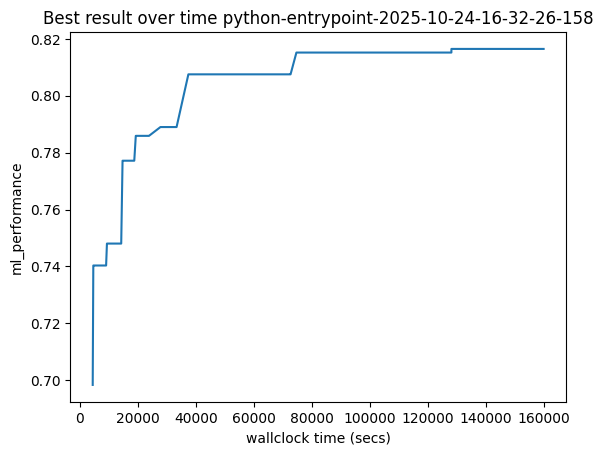

In [3]:
tuning_experiment.plot()

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/syne_tune/experiments/experiment_result.py:177: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


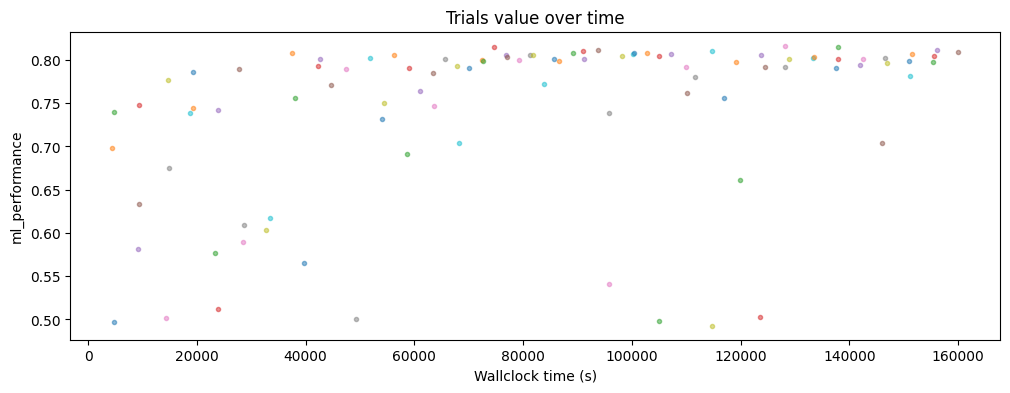

In [4]:
tuning_experiment.plot_trials_over_time()

In [5]:
tuning_experiment.best_config()

{'ml_performance': 0.8164550621571802,
 'recon_loss': 888.1217291974117,
 'trial_id': 76,
 'config_epochs': 250,
 'config_checkpoint_interval': 250,
 'config_loss_reduction': 'sum',
 'config_data_path': './notebooks/large_sc_data/census-processed-chatgpt.pkl',
 'config_ontology_name': 'chatgpt_ontology__',
 'config_tasks': 'cell_type$tissue$development_stage$sex$disease',
 'config_batch_size': 639,
 'config_drop_p': 0.0207278767645456,
 'config_enc_factor': 4,
 'config_weight_decay': 0.0022333930529658,
 'config_beta': 9.388871779937684e-05,
 'config_learning_rate': 0.0022724950672207,
 'config_n_layers': 2}

In [6]:
tuning_experiment.best_config()['config_epochs']

250

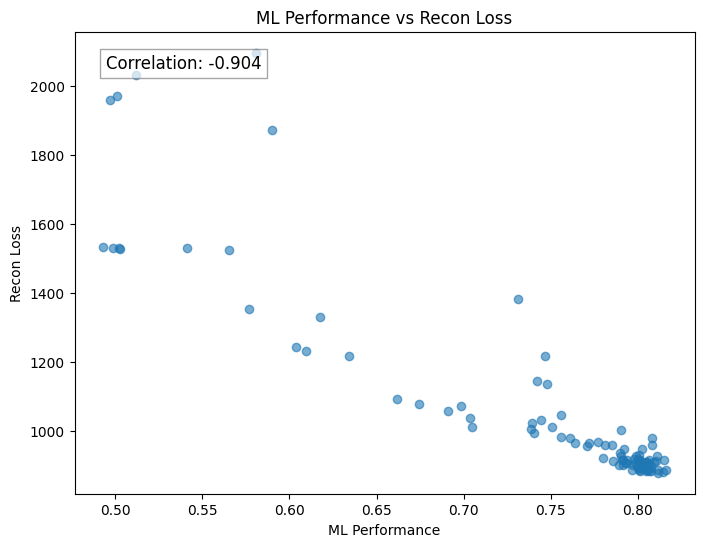

In [7]:
import numpy as np

import matplotlib.pyplot as plt

y = tuning_experiment.results.recon_loss
x = tuning_experiment.results.ml_performance

corr = np.corrcoef(x, y)[0, 1]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.6)
plt.xlabel("ML Performance")
plt.ylabel("Recon Loss")
plt.title("ML Performance vs Recon Loss")
# plt.xlim(0.8, 1.0) ## Limit to good and very good runs
# plt.ylim(500, 600) ##

plt.text(
	0.05, 0.95,
	f"Correlation: {corr:.3f}",
	transform=plt.gca().transAxes,
	fontsize=12,
	verticalalignment='top',
	bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray')
)

plt.show()